In [1]:
import torch
from torch import nn
from torchinfo import summary
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(0)
torch.manual_seed(0)

In [2]:
PATCH_SIZE = 16 # P
IMAGE_CROP = 200
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
NUM_HEADS = 6
NUM_LAYERS = 2
MLP_DROPOUT = 0.1
ATTN_DROPOUT = 0.0
EMBEDDING_DROPOUT = 0.1
MLP_SIZE = 768
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
N_EPOCHS = 10
LR = 0.001

# EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2 # Hidden Size D
EMBEDDING_DIMS = 24

#the image width and image height should be divisible by patch size. This is a check to see that.
assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [3]:
train_transform = transforms.Compose([
    transforms.CenterCrop(IMAGE_CROP),
    transforms.Resize((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

from dataset import create_dataloaders
root_dir = "C:/Users/Jacqu/Downloads/AD_NC"
train_loader, valid_loader, test_loader = create_dataloaders(root_dir, train_transform, test_transform, batch_size=BATCH_SIZE, datasplit=0.8)
print(f"Num batches for train: {len(train_loader)}")
print(f"Num batches for valid: {len(valid_loader)}")

Num batches for train: 269
Num batches for valid: 68


In [4]:
from modules import *
model = ViT(
        img_size=IMAGE_WIDTH,
        in_channels = IMAGE_CHANNELS,
        patch_size = PATCH_SIZE,
        embedding_dim = EMBEDDING_DIMS,
        num_transformer_layers = NUM_LAYERS, # from table 1 above
        mlp_dropout = MLP_DROPOUT,
        attn_dropout = ATTN_DROPOUT,
        embedding_dropout=EMBEDDING_DROPOUT,
        mlp_size = MLP_SIZE,
        num_heads = NUM_HEADS,
        num_classes = NUM_CLASSES).to(device)

summary(model=model,
        input_size=(BATCH_SIZE, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 1, 224, 224]    [64, 2]              4,752                True
├─PatchEmbedding (patch_embedding)                           [64, 1, 224, 224]    [64, 196, 24]        --                   True
│    └─Conv2d (patcher)                                      [64, 1, 224, 224]    [64, 24, 14, 14]     6,168                True
│    └─Flatten (flatten)                                     [64, 24, 14, 14]     [64, 24, 196]        --                   --
├─Dropout (embedding_dropout)                                [64, 197, 24]        [64, 197, 24]        --                   --
├─Sequential (transformer_encoder)                           [64, 197, 24]        [64, 197, 24]        --                   True
│    └─TransformerEncoderBlock (0)                           [64, 197, 24]        [64, 197, 24] 

In [5]:
optimizer = Adam(model.parameters(), 
                lr=LR)
                # weight_decay=0.1,
                # betas=(0.9, 0.999)) # Based on the paper
criterion = CrossEntropyLoss()

In [6]:
from train import train

train_accuracies, valid_accuracies, train_losses, valid_losses = train(model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        n_epochs=N_EPOCHS)

Training: 100%|██████████| 10/10 [04:33<00:00, 27.30s/it]


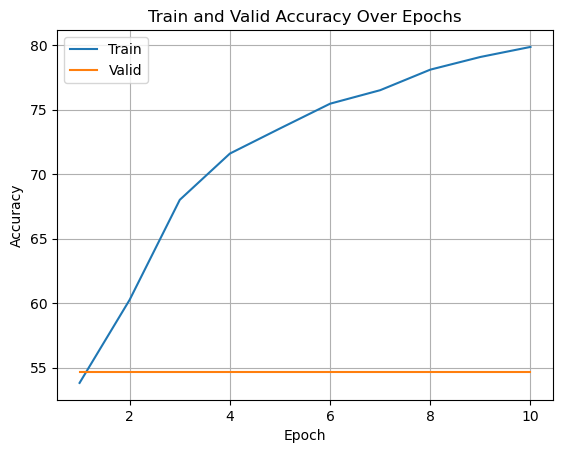

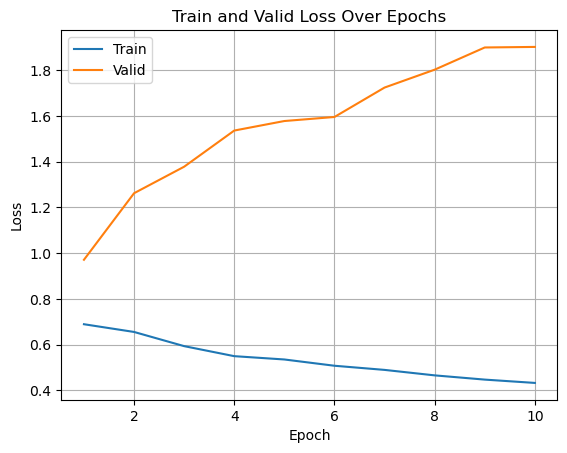

In [7]:
from utils import plot_data

plot_data(train_accuracies, valid_accuracies, labels=['Train', 'Valid'], heading='Accuracy')
plot_data(train_losses, valid_losses, labels=['Train', 'Valid'], heading='Loss')

In [8]:
from predict import test
test(model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device)

Testing: 100%|██████████| 141/141 [00:12<00:00, 11.19it/s]

Test loss: 2.08
Test accuracy: 50.44%
